# Guide to Extracting Data w/ APIs from the Withings Body+ Scale

<img src="https://helios-i.mashable.com/imagery/reviews/004D6FxeJ3thoEUqJ7bum9h/hero-image.fill.size_1248x702.v1648656157.png" width="500"/>

Are smart TVs, smartphones, or smart watches not enough? Introducing the [Withings Body+ Scale](https://www.withings.com/us/en/body-plus), a smart scale that can not only weigh you, but also leverage its Wi-Fi capabilities to enable you to store your historical weight data for your viewing pleasure. While this notebook is meant for the Body+ Scale, it can be easily adapted to any other Withings scale with minor modifications.

Also note that you need to set up your Withings Body+ Scale prior to running this notebook. To do this, simply follow the instructions on the app to (1) pair your phone to your scale and (2) connect your scale to your home internet.

If you want to know more about Withings Body+ Scale, see the [README](https://github.com/alrojo/wearipedia/tree/main/wearables/withings-scale-bodyplus) for a detailed analysis of performances, sensors, data privacy, and extraction pipelines.

The API makes the following parameters available:

Parameter Name  | Sampling Frequency 
-------------------|------------------
Weight (kg)      |  Per weighing
Fat Free Mass (kg) | Per weighing
Fat Ratio (%) | Per weighing
Fat Mass Weight (kg) | Per weighing
Muscle Mass (kg) | Per weighing
Hydration (kg) | Per weighing
Bone Mass (kg) | Per weighing


<br><br>
In this guide, we sequentially cover the following **five** topics to extract from the Withings API:
1. **Setup**
    - 1.1: We include some details about what a clinical study participant may be expected to do, assuming you use the public API as we did.
2. **Authentication/Authorization**
    - This requires a couple extra steps on your part
3. **Data extraction**
    - Due to our own limited sample size, which precludes long time horizon data analysis, we include a data extraction step that loads an artificial dataset we randomly generate.
4. **Data visualization**
    - 4.1: We look at trends in both weight and fat (%) over time (months).
    - 4.2: We also look at how weight varies over the time of day and downsample weight to a single measurement per day.
5. **Data analysis**
    - We aggregate body weight by time of day, then conduct a brief statistical analysis to check whether body weight indeed increases after a meal.


Disclaimer: this notebook is purely for educational purposes. All of the data currently stored in this notebook is purely *synthetic*, meaning randomly generated according to rules we created. Despite this, the end-to-end data extraction pipeline has been tested on our own data, meaning that if you enter your own credentials on your own Colab instance, you can visualize your own *real* data. That being said, we were unable to thoroughly test the timezone functionality, though, since we only have one account, so beware.

# 1. Setup

## 1.1 Study participant setup and usage

To set up the scale itself so that you can run this notebook, download the Withings app and follow the instructions on the app. The app will pair via bluetooth to the scale, creating an interface to connect the scale to Wi-Fi. In our experience, this process was frought with difficulties.

Note that the Wi-Fi network must have no captive portal, only simple username / password authentication. This means that connecting the scale to Wi-Fi may be challenging on a university campus setting, where Wi-Fi is hidden behind layers of authentication. One potential workaround is to view the serial number (which is the same as the MAC address) and register the MAC address through the IT department, which should allow a connection to university campus Wi-Fi.

## 1.2 Library import
Relevant libraries are imported below. Just run the code to import all the libraries.

In [ ]:
#@title Library import + setup

# sneak in the library imports etc. here :)

# We randomly generate a large artificial dataset to make our demo analysis
# more interesting and to avoid using real data. This is not needed for
# data extraction.
!rm -f random_data.csv && wget -q https://gist.githubusercontent.com/stanford-health-wearables/3e5bdd4dfc06a4290038fabf34732ca3/raw/c99a50c1d943903c867364dc6c9a11d83fb4e42a/random_data.csv

# upgrade scipy, since we need "intercept_stderr"
# from https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html
!pip install --upgrade scipy -q

import requests
import urllib
import json
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.ndimage import gaussian_filter
from scipy import stats

# 2. Authentication/Authorization

To be able to make requests to the API, the easiest way is to use the public developer API. This section roughly follows the steps outlined [here](https://developer.dexcom.com/authentication) on their website.

First, follow the non-colab steps listed below:

1. Visit the [developer portal](https://developer.withings.com/) and click "Open Developer Dashboard" on the top right.
2. Once logged in, click "Add an app".
3. For now, you can just click "I don't know" under "Services", accept terms of use, and click "Next".
5. Put whatever you want under "Application Name" (we used `withings-test`), anything under "Application Description", and "https://wbsapi.withings.net/v2/oauth2" under Registered URLs, then click "Done".
    - NOTE: "registered URLs" is intended to be a URL to a webserver you control and can receive requests from. However, in this notebook we are simply using it as a placeholder, as this functionality is not strictly necessary for obtaining your data.

In the end, you should see something like the below.

<img src="https://i.imgur.com/ttWojjU.png"></img>

Now we can proceed with the rest of the notebook.

To be able to make requests to the API and extract the data we need, we need to first issue an access token. This (ephemeral) access token will serve as our key to the data. While, you don't necessarily need to be familiar with how the issuing of the authtoken occurs, you can learn more about it by visiting [the official Withings tutorial](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/get-access/oauth-web-flow/).

In [ ]:
#@title 6. Enter your credentials below (from the application you just created)
CLIENT_ID = "" #@param {type:"string"}
CUSTOMER_SECRET = "" #@param {type:"string"}

STATE = 'string'
ACCOUNT_URL = 'https://account.withings.com'
CALLBACK_URI = 'https://wbsapi.withings.net/v2/oauth2'


payload = {'response_type': 'code',  # imposed string by the api
    'client_id': CLIENT_ID,
    'state': STATE,
    'scope': 'user.info,user.metrics',  # see docs for enhanced scope
    'redirect_uri': CALLBACK_URI,  # URL of this app
    #'mode': 'demo'  # Use demo mode, DELETE THIS FOR REAL APP
}

url = f'{ACCOUNT_URL}/oauth2_user/authorize2?'

for key, value in payload.items():
    url += f'{key}={value}&'

url = url[:-1]

print(url)

https://account.withings.com/oauth2_user/authorize2?response_type=code&client_id=&state=string&scope=user.info,user.metrics&redirect_uri=https://wbsapi.withings.net/v2/oauth2


7. Now visit the above URL and click "Allow this app", and copy the URL you were redirected to into the text field below. Note that if you mess up once, you have to go through the above URL again (including clicking "Allow this app"). Also, the URL is only valid for 30 seconds, so be quick!

In [ ]:
#@title 7. Copy and paste the URL you were redirected to below
redirect_url = "https://wbsapi.withings.net/v2/oauth2?code=e46275ce54994fa6e6eadc50cd4dd45467c01e0e&state=string" #@param {type:"string"}

try:
    code = urllib.parse.parse_qs(urllib.parse.urlparse(redirect_url).query)['code'][0]
except Exception as e:
    print(f'Caught error:\n{e}\n')
    print("Please copy and paste the entire URL (including https)")

params = {
    'action': 'requesttoken',
    'grant_type': 'authorization_code',
    'client_id': CLIENT_ID,
    'client_secret': CUSTOMER_SECRET,
    'code': code,
    #'scope': 'user.info',
    'redirect_uri': 'https://wbsapi.withings.net/v2/oauth2'
}

out = requests.get('https://wbsapi.withings.net/v2/oauth2', data=params)

out = json.loads(out.text)

try:
    access_token = out['body']['access_token']
except KeyError as e:
    print('Took too long to paste in redirect URL. Please repeat step 7.')

Took too long to paste in redirect URL. Please repeat step 7.


Now that we have our access token, we can begin making requests to the API! This access token will last only three hours, though, so you would need to re-do step 7 if three hours pass.

# 3. Data extraction

Here, data extraction is pretty simple! All we need to do is make a GET request with the right query parameters. See [the overall health data API page](https://developer.withings.com/developer-guide/v3/integration-guide/public-health-data-api/data-api/all-available-health-data) or the ["Measure" endpoints specifically](https://developer.withings.com/api-reference#operation/measure-getmeas) for more info, if you want to change up these query parameters for your own usage.

Below you can uncheck the "use_synthetic" box to instead use your own *real* data via Withings API calls!

In [ ]:
#@title Extract data via the API!
use_synthetic = True #@param {type:"boolean"}

num_to_description = {1: 'Weight (kg)',
                      4: 'Height (meter)',
                      5: 'Fat Free Mass (kg)',
                      6: 'Fat Ratio (%)',
                      8: 'Fat Mass Weight (kg)',
                      9: 'Diastolic Blood Pressure (mmHg)',
                      10: 'Systolic Blood Pressure (mmHg)',
                      11: 'Heart Pulse (bpm) - only for BPM and scale devices',
                      12: 'Temperature (celsius)',
                      54: 'SP02 (%)',
                      71: 'Body Temperature (celsius)',
                      73: 'Skin Temperature (celsius)',
                      76: 'Muscle Mass (kg)',
                      77: 'Hydration (kg)',
                      88: 'Bone Mass (kg)',
                      91: 'Pulse Wave Velocity (m/s)',
                      123: 'VO2 max is a numerical measurement of your body’s ability to consume oxygen (ml/min/kg).',
                      135: 'QRS interval duration based on ECG signal',
                      136: 'PR interval duration based on ECG signal',
                      137: 'QT interval duration based on ECG signal',
                      138: 'Corrected QT interval duration based on ECG signal',
                      139: 'Atrial fibrillation result from PPG'}


def fetch_measurements(measure_types='1,6', random_data=False):
    # make public API requests, while specifying the measure_types we desire
    # we make potentially multiple because the public API can return only up
    # to 200 measurements

    if random_data:
        # load in the CSV that we've pre-generated
        df = pd.read_csv('random_data.csv')
        # fix dates, convert to datetime obj from string
        df.date = df.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S.%f'))

        df = df[[col for col in df.columns if "Unnamed: 0" not in col]]

        return df

    cur_offset = 0
    data_complete = []
    while True:
        out = requests.post('https://wbsapi.withings.net/measure', data={
            'action': 'getmeas',
            'meastypes': measure_types,
            'offset': cur_offset
        }, headers={'Authorization': f'Bearer {access_token}'})

        # convert this to python dict and get just the actual time series as
        # a pandas dataframe
        out = json.loads(out.text)
        measurements = out['body']['measuregrps']
        data = [{**{'date': datetime.fromtimestamp(meas['date'])},
                **{num_to_description[meas_val['type']]: meas_val['value'] * 10 ** (meas_val['unit']) for meas_val in meas['measures']}} for meas in measurements]

        data_complete += data

        if 'more' in out['body'].keys() and out['body']['more'] == 1:
            cur_offset = cur['body']['offset']
        else:
            break

    df = pd.DataFrame(data)

    return df


df = fetch_measurements(random_data=use_synthetic)
df

,date,Weight (kg),Fat Ratio (%)
0,2020-01-01 16:00:20.835392,68.281531,27.600354
1,2020-01-01 10:49:38.738726,68.798625,29.339849
2,2020-01-02 20:20:00.887639,68.354385,28.474596
3,2020-01-02 14:49:07.478133,68.778135,29.911508
4,2020-01-02 23:45:25.764174,66.428940,28.372731
...,...,...,...
1375,2022-05-14 19:18:22.484972,62.143377,17.195181
1376,2022-05-15 12:03:44.424457,60.446983,14.965986
1377,2022-05-16 20:46:23.244587,57.514826,15.528326
1378,2022-05-16 21:08:47.633776,59.242820,14.460136


# 4. Data Visualization

Our artificial dataset is sourced from a fictitious person who has undergone treatment with Arilitaxel, a fictitious revolutionary weight loss medication, for the past two years, in addition to calorie restriction and regular exercise.

## 4.1: Long-term visualization

Now we can try to visualize some of the data we got back from Withings. Specifically, we will plot body weight over time (also Gaussian-filtered, to get a clearer sense of the trend), coloring the periods before treatment begins and after treatment begins. We also highlight a period (by leaving it out) where the user either went on vacation or forgot to use the scale for at least 5 days.

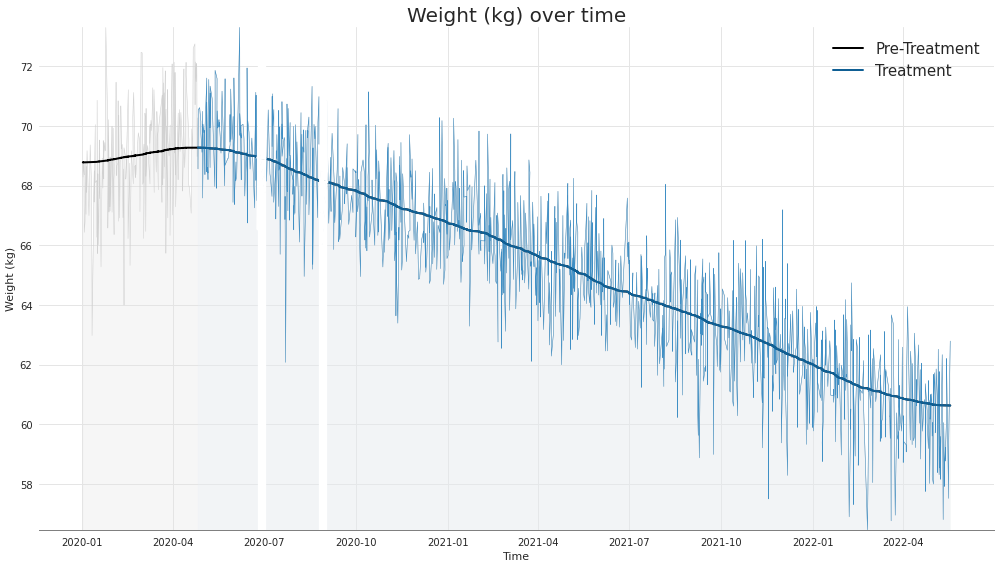

In [ ]:
#@title Plot all of the data

from scipy.ndimage import gaussian_filter

# treatment starts at index 200
TREATMENT_START_IDX = 200

# 2 days
MIN_NEEDED_FOR_BREAK = 5 * 24 * 3600

x_timestamp = np.array(df.date.apply(lambda x: x.timestamp()))

# get the gaps. we include [6] as well because when you do np.diff,
# it actually leaves out exactly one element
differences = np.concatenate((np.diff(x_timestamp), [6]))

# interpret a gap (i.e. when a user takes off the device for some prolonged
# period of time) as any two measurements that are taken more than
# MIN_NEEDED_FOR_BREAK seconds apart
gap_idxes = np.where(differences > MIN_NEEDED_FOR_BREAK)[0]

with plt.style.context('seaborn'):
    plt.figure(figsize=(14,8))

    # filter the weight so that it looks smoother
    filtered = gaussian_filter(df['Weight (kg)'], 100)

    # plot the weight curve and its filtered counterpart
    plt.plot(df.date, df['Weight (kg)'], linewidth=.5, color='#d1d1d1')
    plt.plot(df.date, filtered, linewidth=2, color='black', label='Pre-Treatment')

    # plot the fill from x-axis up to weight curve
    plt.fill_between(df.date, df['Weight (kg)'], color='#e3e3e3', alpha=0.3)

    # overlay treatment color
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             df['Weight (kg)'].iloc[TREATMENT_START_IDX:],
             linewidth=0.5, color='#3f8fc5')
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             filtered[TREATMENT_START_IDX:],
             linewidth=2, color='#0f5f94', label='Treatment')
    plt.fill_between(df.date.iloc[TREATMENT_START_IDX:],
                     df['Weight (kg)'].iloc[TREATMENT_START_IDX:],
                     color='#eaf1f6', alpha=0.3)

    # overlay gaps
    for gap_idx in gap_idxes:
        plt.plot(df.date.iloc[gap_idx-3:gap_idx+3], df['Weight (kg)'].iloc[gap_idx-3:gap_idx+3], linewidth=2, color='white')
        plt.plot(df.date.iloc[gap_idx-2:gap_idx+2], filtered[gap_idx-2:gap_idx+2], linewidth=3, color='white')
        plt.fill_between(df.date.iloc[gap_idx-3:gap_idx+3], df['Weight (kg)'].iloc[max(gap_idx-100,0):gap_idx+100].max(), color='white')


    plt.title('Weight (kg) over time', fontsize=20)
    plt.ylabel('Weight (kg)')
    plt.xlabel('Time')

    # set background color *inside the figure*
    plt.gca().set_facecolor(color='white')

    # add horizontal grid
    plt.gca().grid(axis='x', color='#e5e5e5')
    plt.gca().grid(axis='y', color='#e5e5e5', which='major')

    # ensure the bottom axis is slightly darker and extends all the way
    # to the left
    plt.gca().spines['bottom'].set_edgecolor('grey')
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['bottom'].set_visible(True)

    plt.ylim(df['Weight (kg)'].min(), df['Weight (kg)'].max())

    plt.legend(prop={'size': 15})

    plt.tight_layout()

Looks like the user lost lots of weight! The treatment seems to have had a positive effect.

Let's take a look at body fat (%) now.

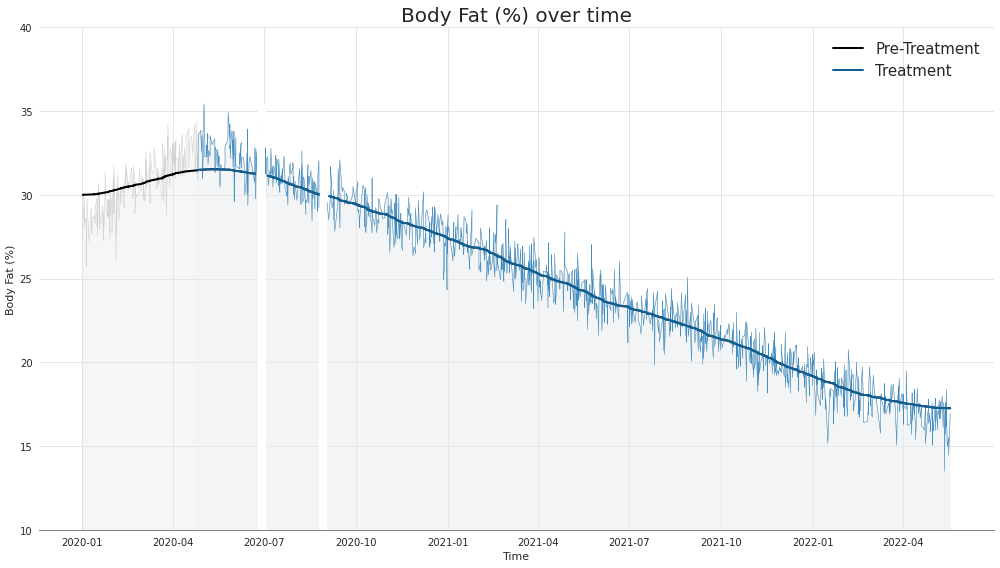

In [ ]:
#@title Plot body fat curve
from scipy.ndimage import gaussian_filter

# 2 days
MIN_NEEDED_FOR_BREAK = 5 * 24 * 3600

x_timestamp = np.array(df.date.apply(lambda x: x.timestamp()))

# get the gaps. we include [6] as well because when you do np.diff,
# it actually leaves out exactly one element
differences = np.concatenate((np.diff(x_timestamp), [6]))

# interpret a gap (i.e. when a user takes off the device for some prolonged
# period of time) as any two measurements that are taken more than
# MIN_NEEDED_FOR_BREAK seconds apart
gap_idxes = np.where(differences > MIN_NEEDED_FOR_BREAK)[0]

with plt.style.context('seaborn'):
    plt.figure(figsize=(14,8))

    filtered = gaussian_filter(df['Fat Ratio (%)'], 100)

    # plot everything
    plt.plot(df.date, df['Fat Ratio (%)'], linewidth=.5, color='#d1d1d1')
    plt.plot(df.date, filtered, linewidth=2, color='black', label='Pre-Treatment')

    plt.fill_between(df.date, df['Fat Ratio (%)'], color='#e3e3e3', alpha=0.3)

    # overlay treatment
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             df['Fat Ratio (%)'].iloc[TREATMENT_START_IDX:], linewidth=0.5, color='#3f8fc5')
    plt.plot(df.date.iloc[TREATMENT_START_IDX:],
             filtered[TREATMENT_START_IDX:],
             linewidth=2, color='#0f5f94', label='Treatment')
    plt.fill_between(df.date.iloc[TREATMENT_START_IDX:],
                     df['Fat Ratio (%)'].iloc[TREATMENT_START_IDX:],
                     color='#eaf1f6', alpha=0.3)

    # overlay gaps
    for gap_idx in gap_idxes:
        plt.plot(df.date.iloc[gap_idx-3:gap_idx+3], df['Fat Ratio (%)'].iloc[gap_idx-3:gap_idx+3], linewidth=2, color='white')
        plt.plot(df.date.iloc[gap_idx-2:gap_idx+2], filtered[gap_idx-2:gap_idx+2], linewidth=3, color='white')
        plt.fill_between(df.date.iloc[gap_idx-3:gap_idx+3], df['Fat Ratio (%)'].iloc[max(gap_idx-100,0):gap_idx+100].max(), color='white')

    plt.title('Body Fat (%) over time', fontsize=20)
    plt.ylabel('Body Fat (%)')
    plt.xlabel('Time')

    # set background color *inside the figure*
    plt.gca().set_facecolor(color='white')

    # add horizontal grid
    plt.gca().grid(axis='x', color='#e5e5e5')
    plt.gca().grid(axis='y', color='#e5e5e5', which='major')

    # ensure the bottom axis is slightly darker and extends all the way
    # to the left
    plt.gca().spines['bottom'].set_edgecolor('grey')
    plt.gca().spines['bottom'].set_linewidth(1)
    plt.gca().spines['bottom'].set_visible(True)

    plt.ylim(10, 40)

    plt.legend(prop={'size': 15})

    plt.tight_layout()

Looks like we also lost some body fat, about half!

## 4.2: Time of day

It might also be interesting to look at how these quantities vary over the time of day. We'll aggregate all measurements by the hour of the day they were taken, then do a violin plot.

Text(0.5, 1.0, 'Weight by time of day')

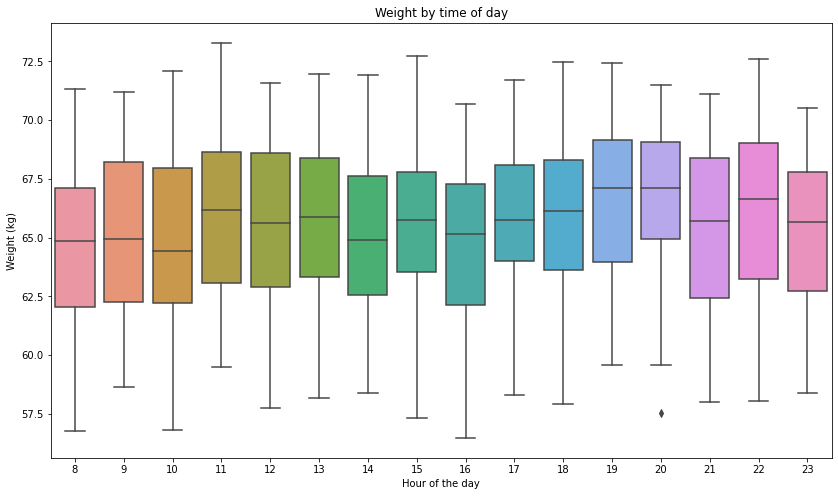

In [ ]:
#@title Plot weight by time of day
df['Hour of the day'] = df.date.apply(lambda x: x.hour)

plt.figure(figsize=(14,8))
sns.boxplot(x='Hour of the day', y='Weight (kg)', data=df)
plt.title('Weight by time of day')

Looks like things vary quite a bit by time of day, and the user also seems to have taken more than one measurement per day on average (given that we have ~1400 measurements over the course of just two years). What if we want to just get a single weight value for each day the user has weighed themselves?

Let's solve this problem by doing the following. Choose a time to be the canonical weighing time, say 5pm (technically speaking, 5pm-6pm). If a user has weighed themselves during that time interval, do nothing. If a user weighed themselves at some other time, say 3pm, then just add an offset corresponding to the average offset between weighings at 3pm and 5pm.

If a user has weighed themselves at multiple points other than 5pm, just average their corrected weight values.

To deduce the average offsets in the first place, just go through and find each instance where the user weighed themselves at 5pm, look in the neighborhood of 5 days within that day, and compute the offsets for the hours captured by those measurements.

In [ ]:
#@title Get the offsets
days = df.date.apply(lambda x: x.timestamp()) / (24 * 3600)

# note that index 17 should be garbage, we don't care about it
offsets = [[] for i in range(24)]

for idx in np.where(df['Hour of the day'] == 17)[0]:
    to_offset = df['Hour of the day'].iloc[np.where(np.abs(days[idx] - days) < 5)[0]]

    for i, val in zip(to_offset.index, to_offset):
        offsets[val].append(df['Weight (kg)'].iloc[idx] - df['Weight (kg)'].iloc[i])


def compute_mean(x):
    if len(x) > 0:
        return np.mean(x)
    else:
        return 0

offsets = [compute_mean(offset) for offset in offsets]

Now that we have our offsets we can create a new dataframe that is just the downsampled version of what we already had, but now just one value per day!

In [ ]:
#@title Get downsampled dataframe
downsampled_dict = []

for day in range(int(days.iloc[0]), int(days.iloc[-1])):
    # check if there are any measurements here
    day_idxes = np.where(days.apply(lambda x: int(x)) == day)[0]

    # if there are, do offset
    corrected_weights = []
    for day_idx in day_idxes:
        corrected_weight = df['Weight (kg)'].iloc[day_idx] + offsets[df['Hour of the day'].iloc[day_idx]]
        corrected_weights.append(corrected_weight)

    # save
    if len(corrected_weights) > 0:
        row = {
            'date': datetime.fromtimestamp(day * 24 * 3600),
            'Weight (kg)': np.mean(corrected_weights)
        }

        downsampled_dict.append(row)

downsampled_df = pd.DataFrame.from_dict(downsampled_dict)
downsampled_df

,date,Weight (kg)
0,2020-01-01,69.003367
1,2020-01-02,67.755449
2,2020-01-03,66.599716
3,2020-01-04,68.204664
4,2020-01-05,69.622622
...,...,...
647,2022-05-12,58.039862
648,2022-05-13,59.494033
649,2022-05-14,60.823615
650,2022-05-15,60.030781


As you can see, we've now got a dataframe without any repeating days!

# 5. Data Analysis

Let's try to look for some trends.

## 5.1: Before and after meal

First, let's confirm that the weights after meals are greater than the weights before meals.

Note that this is slightly trickier than simply aggregating all of the weighings that occurred before a meal together and aggregating all of the weighings that occurred after a meal together, then comparing, since the user lost weight. This is because these local fluctuations are much smaller than the change due to the treatment over the course of two years, so they will be washed out.

So instead we'll compare weighings to the weighings immediately surrounding them, and see if weighings that occurred after a meal tend to be higher. First, we'll compute a new column that represents whether the weighing was before a meal, after a meal, or neither.

In [ ]:
def apply_func(x):
    hour = int(x.strftime('%H'))

    if hour in [12+4,12+5]:
        return 'before'
    elif hour in [12+7,12+8,12+9]:
        return 'after'
    else:
        return 'N/A'

df['meal_relative'] = df.date.apply(apply_func)

Now that we have this column, let's compute the deviation of each weighing to their neighboring weighings using a Gaussian filter.

In [ ]:
df['weight_deviations'] = df['Weight (kg)'] - gaussian_filter(df['Weight (kg)'], sigma=100)

Now we can finally check this hypothesis!

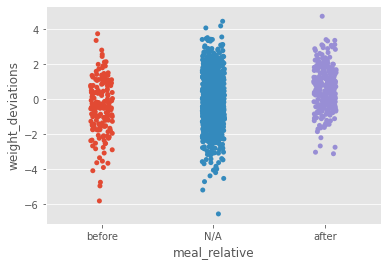

In [ ]:
with plt.style.context('ggplot'):
    sns.stripplot(x='meal_relative', y='weight_deviations', data=df)

It looks like whether the user just ate a meal or not has an impact on the weight. In fact, we can check the difference in the mean of both groups below.

In [ ]:
print(f'Mean of weight deviation for weighings before a meal: {df.weight_deviations[df.meal_relative == "before"].mean():.3g}')
print(f'Mean of weight deviation for weighings after a meal: {df.weight_deviations[df.meal_relative == "after"].mean():.3g}')

Mean of weight deviation for weighings before a meal: -0.474
Mean of weight deviation for weighings after a meal: 0.629


Let's check that this is significant with a two-tailed T-test.

In [ ]:
result = stats.ttest_ind(df.weight_deviations[df.meal_relative == 'before'],
                         df.weight_deviations[df.meal_relative == 'after'])

print(f'P-value is {result.pvalue:.3g}')

P-value is 1.52e-14


It's significant!

## 5.2: Treatment effectiveness

While with only one person's data it is impossible to conclusively state that the treatment has or has not been effective (there is no control group), we can perform a linear regression, which provides a quantitative basis for the promising trend in weight we've seen in the plots in section 4.

Specifically, we will perform a linear regression on the datapoints $(x,y)$, where $x$ is the timestamp and $y$ is the weight, strictly after the treatment start (index 200) and check its p-value. First, we'll just plot this out to remind ourselves what the data looks like.

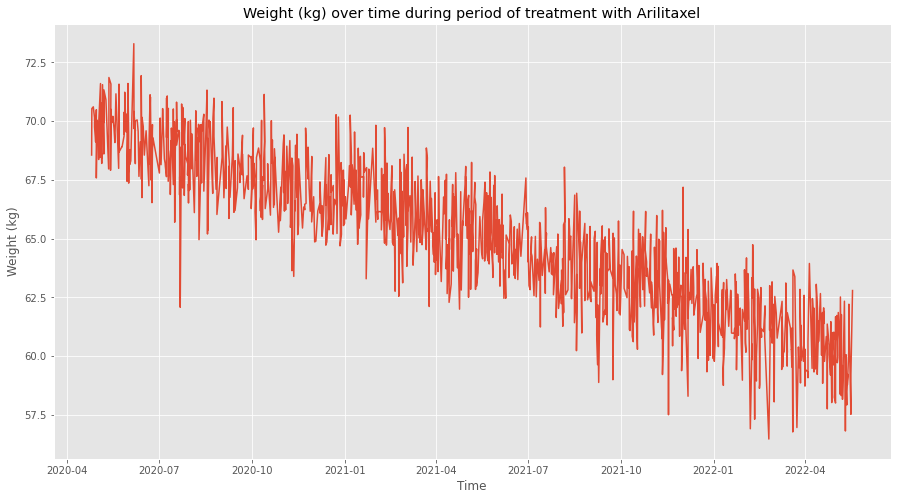

In [ ]:
df['Timestamp'] = df.date.apply(lambda x: x.timestamp())

with plt.style.context('ggplot'):
    plt.figure(figsize=(15,8))
    plt.plot(df.iloc[200:].date, df.iloc[200:]['Weight (kg)'])
    plt.xlabel('Time')
    plt.ylabel('Weight (kg)')
    plt.title('Weight (kg) over time during period of treatment with Arilitaxel')

Looks pretty convincing! Let's do the statistical test now to confirm this quantitatively.

In [ ]:
from scipy import stats
from scipy.stats import t

res = stats.linregress(df['Timestamp'].iloc[200:],
                       df['Weight (kg)'].iloc[200:])

tinv = lambda p, df: abs(t.ppf(p/2, df))
ts = tinv(0.05, len(df.date)-2)

print(f'Slope (95% confidence): {res.slope:.3g} +/- {ts*res.stderr:.3g}')
print(f'Intercept (95% confidence): {res.intercept:.6f}'
      f' +/- {ts*res.intercept_stderr:.6f}')
print(f'Coefficient of determination: {res.rvalue**2:.3g}')
print(f'p-value: {res.pvalue:.3g}')

Slope (95% confidence): -1.5e-07 +/- 4.48e-09
Intercept (95% confidence): 307.562480 +/- 7.263496
Coefficient of determination: 0.785
p-value: 0


Looks significant, and the confidence intervals for the slope and y-intercept are pretty tight! Below we plot what these confidence intervals entail, visually.

Text(0.5, 1.0, 'Weight (kg) over time during period of treatment with Arilitaxel')

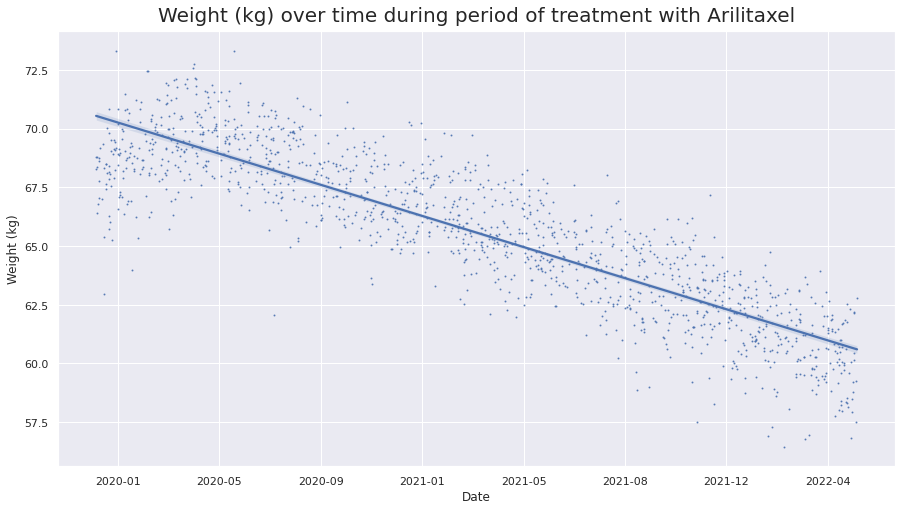

In [ ]:
sns.set(rc = {'figure.figsize':(15,8)})

# Note 1: c=95 to ensure that CI is 95%
# Note 2: plotting timestamp but then replacing tick labels, since
# dates don't work with sns.regplot
sns.regplot(x='Timestamp', y='Weight (kg)', data=df, scatter_kws={'s':1}, ci=95)

ax = plt.gca()
xticks = ax.get_xticks()
xticks_dates = [datetime.fromtimestamp(x).strftime('%Y-%m') for x in xticks]
ax.set_xticklabels(xticks_dates)

plt.xlabel('Date')

plt.title('Weight (kg) over time during period of treatment with Arilitaxel', fontsize=20, pad=10)

We can barely see the confidence interval, and that's because the data is so structured that we are very confident about where the line lies!